<a href="https://colab.research.google.com/github/JohnVicke/deep-learning/blob/main/CNN_laboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN_Laboration
```
Author: Viktor Malmedal
Mail:   viktormalmedal@gmail.com
umuId:  vima0068
```

In [161]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

import tensorflow.keras 
print(f'Keras version:      {tensorflow.keras.__version__}')

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.7.0
Keras version:      2.7.0


In [162]:
import sys
if not tf.config.list_physical_devices('GPU'):
    print('No GPU detected. CNNs can be very slow without a GPU')
    if 'google.colab' in sys.modules:
        print('Go to RunTime > change runtime and select a GPU hardware accelerator')
else:
    !nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4caadcba-5018-c18b-4e3c-d41d4361162c)


In [163]:
def split_random(data, labels, percent_train=80):
    print('Splitting data into training and validation')
    print(f'Training split     = {percent_train}%')
    print(f'Validation split   = {100-percent_train}%')
    indicies = np.arange(data.shape[0])

    for _ in range(4): 
        indicies = np.random.permutation(indicies)

    
    labels = labels[indicies]
    data = data[indicies]
    rows = data.shape[0]

    end_index = int(rows*percent_train/100)

    train_x = data[:end_index]
    train_y = labels[:end_index]

    validation_x = data[end_index:]
    validation_y = labels[end_index:]

    return (train_x, train_y), (validation_x, validation_y)

In [164]:
def validate_data(data, labels, data_set_name):
    """
        Naive validation, only validets shape of data compared to labels
    """

    nr_images, x, y = data.shape
    print(f'\nRunning validation on {data_set_name}')
    print(f'Number of images   = {nr_images}')
    print(f'Number of labels   = {len(labels)}')
    print(f'Image dimension    = {x}x{y}')
    if nr_images != len(labels):
        print('Number of images does not match number of labels')
    else:
        print('Data is OK ✅')

In [165]:
def get_class_dist(data):
    dist = {}
    for label in data:
        if label in dist:
            dist[label] += 1
        else:
            dist[label] = 1
    return dist


In [166]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
label_descriptions = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat',
                      'sandals', 'shirt', 'sneaker', 'bag', 'ankle boots']

(train_x, train_y), (validation_x, validation_y) = split_random(x_train, y_train)

# increase readability since i will use train_x, train_y from here on 
test_x = x_test
test_y = y_test
test_labels = y_test

validate_data(train_x, train_y, "training")
validate_data(validation_x, validation_y, "validation")
validate_data(test_x, test_y, "test")
distribution = get_class_dist(train_y)

print(f'\nTrain shape         = {train_x.shape}')
print(f'Validation shape    = {validation_x.shape}')
print(f'Test shape          = {x_test.shape}')
print(f'Unique labels       = {np.unique(train_y)}')
print('Label translation   = ---------------------')
for i, label in enumerate(label_descriptions):
    print(f'                     [{i}]: {label}')
print('Train distribution  = ---------------------')
for i, label in enumerate(label_descriptions):
    print('                     {:<20s}: {}'.format(label_descriptions[i], distribution[i]))
print('                     ---------------------')

Splitting data into training and validation
Training split     = 80%
Validation split   = 20%

Running validation on training
Number of images   = 48000
Number of labels   = 48000
Image dimension    = 28x28
Data is OK ✅

Running validation on validation
Number of images   = 12000
Number of labels   = 12000
Image dimension    = 28x28
Data is OK ✅

Running validation on test
Number of images   = 10000
Number of labels   = 10000
Image dimension    = 28x28
Data is OK ✅

Train shape         = (48000, 28, 28)
Validation shape    = (12000, 28, 28)
Test shape          = (10000, 28, 28)
Unique labels       = [0 1 2 3 4 5 6 7 8 9]
Label translation   = ---------------------
                     [0]: t-shirt/top
                     [1]: trouser
                     [2]: pullover
                     [3]: dress
                     [4]: coat
                     [5]: sandals
                     [6]: shirt
                     [7]: sneaker
                     [8]: bag
                     [9]: a

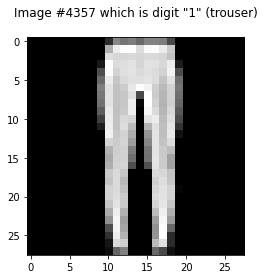

In [167]:
from random import randrange
def plot_image(digit):
    plt.figure()
    plt.imshow(train_x[digit], cmap='gray', interpolation='nearest')
    plt.title(f'Image #{digit} which is digit "{train_y[digit]}" ({label_descriptions[train_y[digit]]})\n')
    plt.show(block=False)

ran_range = len(train_x) - 1
image_digits = [randrange(ran_range)]
plots = [plot_image(a) for a in image_digits]


<Figure size 432x288 with 0 Axes>

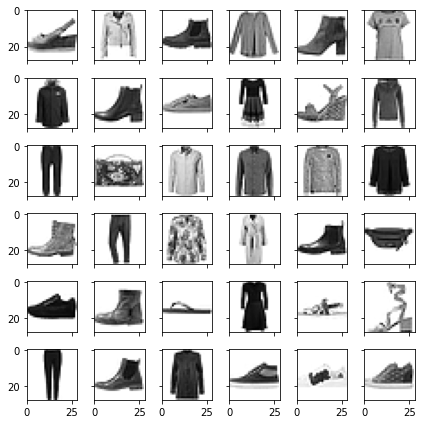

In [168]:
from random import sample
ROWS = 6
random_indicies = sample(range(train_x.shape[0]), ROWS*ROWS)
sample_images = train_x[random_indicies, :]
plt.clf()
fig, axes = plt.subplots(ROWS, ROWS, 
                         figsize=(ROWS, ROWS),
                         sharex=True, sharey=True)

for i in range(ROWS*ROWS):
    subplot_row = i // ROWS
    subplot_col = i % ROWS
    ax = axes[subplot_row, subplot_col]
    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

In [169]:
def reshape_data(data, img_width, img_height, channels_first):
    data = data.astype('float32') / 255.0

    if channels_first:
        data = data.reshape(data.shape[0], 1, img_width, img_height)
    else:
       data = data.reshape(data.shape[0], img_width, img_height, 1) 

    return data


In [170]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [171]:
def retrieve(mapping, *keys):
    return (mapping[key] for key in keys)

In [172]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Declaring global variables
epochs = 15
batch_size = 32
nr_classes = len(np.unique(train_y))
_, img_width, img_height = train_x.shape
is_channels_first = backend.image_data_format() == 'channels_first'
input_shape = (1, img_width, img_height) if is_channels_first else (img_width, img_height, 1)

train_x = reshape_data(train_x, img_width, img_height, is_channels_first)
test_x = reshape_data(test_x, img_width, img_height, is_channels_first)
validation_x = reshape_data(validation_x, img_width, img_height, is_channels_first)

train_y = to_categorical(train_y, nr_classes)
test_y = to_categorical(test_y, nr_classes)
validation_y = to_categorical(validation_y, nr_classes)

training_data = (train_x, train_y)
validation_data = (validation_x, validation_y)
models = []

In [173]:
class CNNModel():
    history = None
    score   = None

    def __init__(self, sequential, name):
        self.name = name
        self.sequential = sequential

    def compile(self):
        optimizer = optimizers.Adam(learning_rate=0.0001)
        self.sequential.compile(loss='categorical_crossentropy',
                                optimizer=optimizer,
                                metrics=['categorical_accuracy'])
    
    def train(self, training_data, validation_data, verbose=1):
        callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        history = self.sequential.fit(train_x, train_y, 
                                      batch_size=batch_size, 
                                      epochs=epochs,
                                      verbose=verbose,
                                      validation_data=validation_data,
                                      callbacks=callbacks)
        self.history = history.history
    
    def evaluate(self):
        score = self.sequential.evaluate(test_x, test_y)
        self.score = score

    def plot_history(self):
        train_loss, train_acc, val_loss, val_acc = retrieve(self.history, 
                                                            'loss',
                                                            'categorical_accuracy',
                                                            'val_loss',
                                                            'val_categorical_accuracy')
        epoch_range = range(1, epochs + 1)
        plt.plot(epoch_range, train_acc, 'bo', label='Training accuracy')
        plt.plot(epoch_range, val_acc, 'b', label='Validation accuracy')
        plt.title(f'Training and validation accuracy ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.plot(epoch_range, train_loss, 'bo', color='red', label='Training loss')
        plt.plot(epoch_range, val_loss, 'b', color='red', label='Validation loss')
        plt.title(f'Training and validation loss ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        print()
    

In [174]:
one_layer_cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), 
           activation='relu', 
           input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])

models.append(CNNModel(one_layer_cnn, 'One layer CNN with 3x3 kernel'))

In [175]:
seq_6x6 = Sequential([
    Conv2D(32, kernel_size=(6,6), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])

models.append(CNNModel(seq_6x6, 'One layered CNN with 6x6 kernel'))

In [176]:
two_layer_cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), 
           activation='relu', 
           input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])

models.append(CNNModel(two_layer_cnn, 'Two layered CNN'))

In [177]:
complex_cnn = Sequential([

    Conv2D(32, kernel_size=(3,3), padding='same', 
           activation='relu',
           input_shape=input_shape),
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax'),
])

models.append(CNNModel(complex_cnn, 'Complex multilayered CNN'))

In [178]:
import time
for model in models:
    print(f'Begin training model: {model.name}')
    start_time = time.time();
    model.compile()
    model.train(training_data, validation_data)
    elapsed_time = time.time() - start_time
    print(f'Training finished in {hms_string(elapsed_time)}\n')


Begin training model: One layer CNN with 3x3 kernel
Epoch 1/15
1500/1500 [==============================] - 10s 6ms/step - loss: 0.6042 - categorical_accuracy: 0.7988 - val_loss: 0.4241 - val_categorical_accuracy: 0.8537
Epoch 2/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4010 - categorical_accuracy: 0.8607 - val_loss: 0.3648 - val_categorical_accuracy: 0.8744
Epoch 3/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3613 - categorical_accuracy: 0.8740 - val_loss: 0.3463 - val_categorical_accuracy: 0.8755
Epoch 4/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3374 - categorical_accuracy: 0.8809 - val_loss: 0.3183 - val_categorical_accuracy: 0.8838
Epoch 5/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3207 - categorical_accuracy: 0.8869 - val_loss: 0.3076 - val_categorical_accuracy: 0.8888
Epoch 6/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3069 - categorical_accuracy: 

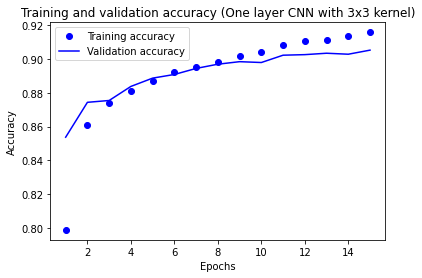

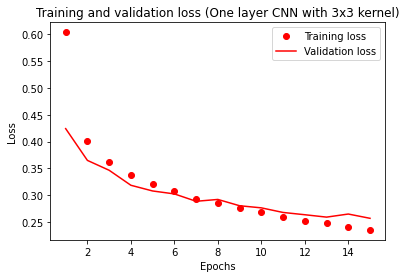

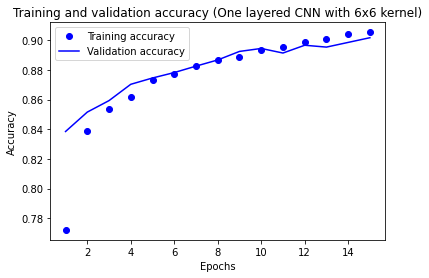

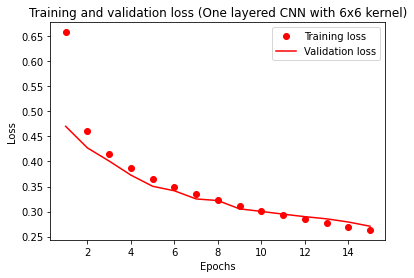

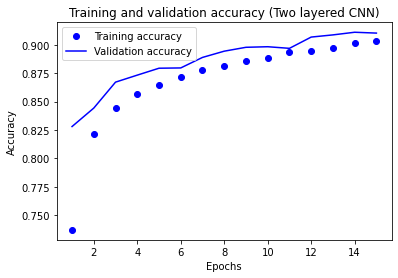

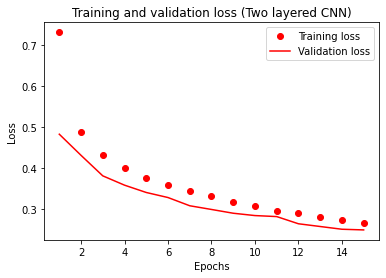

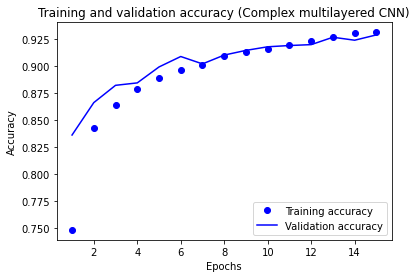

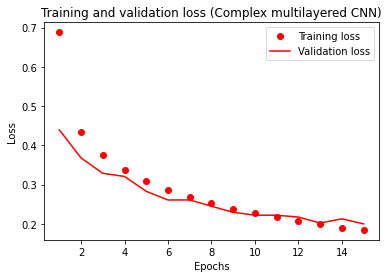

In [179]:
for model in models:
    model.plot_history()

In [180]:
for model in models: 
    model.evaluate()

best_acc = max(models, key=lambda m: m.score[1])
least_loss = min(models, key=lambda m: m.score[0])

313/313 [==============================] - 2s 7ms/step - loss: 0.2137 - categorical_accuracy: 0.9227


In [181]:
print(f'Model with highest test accuracy: {best_acc.name}')
print(f'Test accuracy = {best_acc.score[1]}')
print()
print(f'Model with lowest loss: {least_loss.name}')
print(f'Loss          = {least_loss.score[0]}')

Model with highest test accuracy: Complex multilayered CNN
Test accuracy = 0.9226999878883362

Model with lowest loss: Complex multilayered CNN
Loss          = 0.21373337507247925


In [182]:
for model in models:
    predictions = model.sequential.predict(test_x[:5])
    print(f'Letting model {model.name} predict on 5 samples')
    print(f'Model predicted labels     = {np.argmax(predictions, axis=1)}')
    print(f'Actual labels are          = {test_labels[:5]}')
    print()

Letting model One layer CNN with 3x3 kernel predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]

Letting model One layered CNN with 6x6 kernel predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]

Letting model Two layered CNN predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]

Letting model Complex multilayered CNN predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]

